In [421]:
import sys

sys.path.append("../")

In [422]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
DATA_PATH = '../data/1h'

In [423]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 
           'LINK', 'BCH', 'LTC', 'ALGO', 'AVAX', 'ICP', 'WBTC', 'FTT', 'MATIC', 'FIL', 'XLM', 'VET', 'ETC', 'TRX', 'THETA']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2019-01-01'
test_end = '2020-12-01'
end_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        df = df[df.index < end_date].copy()
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,...,AVAX-USDT,ICP-USDT,FTT-USDT,MATIC-USDT,FIL-USDT,XLM-USDT,VET-USDT,ETC-USDT,TRX-USDT,THETA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,8.368422,5.709135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,8.369927,5.714063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,8.372017,5.712676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,8.377929,5.729970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,8.380386,5.732111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [424]:
df.tail()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,...,AVAX-USDT,ICP-USDT,FTT-USDT,MATIC-USDT,FIL-USDT,XLM-USDT,VET-USDT,ETC-USDT,TRX-USDT,THETA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2021-05-31 19:00:00,10.514982,7.873674,0.507962,5.841833,3.453379,-0.005917,-1.135318,3.099552,1.833701,3.313095,...,2.865396,4.714921,3.506758,0.604125,4.257172,-0.937080,-2.120514,4.217565,-2.590401,1.903003
2021-05-31 20:00:00,10.509852,7.862832,0.512344,5.840147,3.448431,-0.007730,-1.131218,3.100813,1.844668,3.299202,...,2.866534,4.707456,3.500620,0.603687,4.252914,-0.940455,-2.125779,4.219699,-2.589201,1.911467
2021-05-31 21:00:00,10.516849,7.873841,0.520281,5.849267,3.470132,0.001599,-1.125162,3.109463,1.845300,3.313895,...,2.874412,4.719391,3.508436,0.617437,4.265633,-0.938255,-2.110478,4.224729,-2.584550,1.929200
2021-05-31 22:00:00,10.515404,7.880256,0.530922,5.852921,3.470101,0.009950,-1.126641,3.122101,1.864545,3.321396,...,2.878693,4.720194,3.511396,0.625131,4.264087,-0.930795,-2.098584,4.226527,-2.584285,1.943479
2021-05-31 23:00:00,10.525510,7.903282,0.552332,5.867402,3.488903,0.040086,-1.122178,3.146907,1.878854,3.340704,...,2.898119,4.741884,3.527125,0.626612,4.283862,-0.910234,-2.072426,4.248767,-2.566681,1.960939


In [425]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[(df.index <= test_end)][symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [426]:

import itertools as it

nb_symbols = 4
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2,sid_3,sid_4
0,"[10.422070586375366, -15.280142694363569, -3.5...",ADA-USDT,BNB-USDT,XRP-USDT,AVAX-USDT
1,"[1.0018574846212847, 0.14512874172531834, -8.2...",BNB-USDT,SOL-USDT,ALGO-USDT,AVAX-USDT
2,"[3.4124961112657592, 4.829848295094163, -9.851...",XRP-USDT,DOT-USDT,ETC-USDT,TRX-USDT
3,"[8.575350019284887, -31.078048316446445, 10.01...",XRP-USDT,LUNA-USDT,AVAX-USDT,ETC-USDT
4,"[10.768026601562783, -22.237914057008577, 14.3...",XRP-USDT,LUNA-USDT,AVAX-USDT,TRX-USDT


In [427]:
coint_df.to_csv('coint_df.csv')


In [428]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df[(df.index <= test_end)].copy()
        spread = calculate_spread(df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

In [429]:
stationary_df

,i,pairs,half_life
7,7,"[DOGE-USDT, DOT-USDT, LUNA-USDT, TRX-USDT]",-53176.374115
2,2,"[XRP-USDT, DOT-USDT, ETC-USDT, TRX-USDT]",-6721.011847
10,10,"[DOT-USDT, LUNA-USDT, ALGO-USDT, TRX-USDT]",265.066354
9,9,"[DOT-USDT, LUNA-USDT, LINK-USDT, TRX-USDT]",349.157616
11,11,"[DOT-USDT, LUNA-USDT, VET-USDT, TRX-USDT]",482.381779
14,14,"[DOT-USDT, LUNA-USDT, TRX-USDT, THETA-USDT]",590.650713
12,12,"[DOT-USDT, LUNA-USDT, ETC-USDT, TRX-USDT]",601.868106
5,5,"[XRP-USDT, AVAX-USDT, ETC-USDT, TRX-USDT]",788.690350
0,0,"[ADA-USDT, BNB-USDT, XRP-USDT, AVAX-USDT]",1136.159778
8,8,"[DOGE-USDT, DOT-USDT, ETC-USDT, TRX-USDT]",1750.763069


In [430]:
selected_row = stationary_df[stationary_df['i'] == 10]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df[df.index <= test_end], selected_row, hedge_ratio)

10


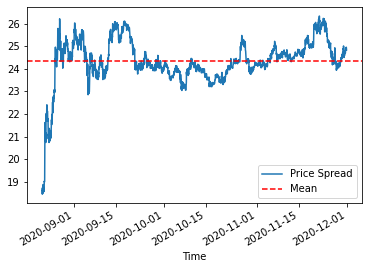

In [431]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [432]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

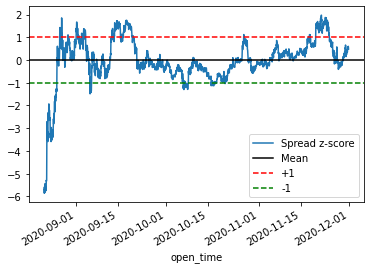

In [433]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

In [434]:
eval_spread = calculate_spread(df[df.index >= test_end], selected_row, hedge_ratio)
# eval_spread = eval_spread[:100]

indicator_bb = BollingerBands(close=eval_spread, n=20, ndev=2)
# Add Bollinger Bands features
bb_m = indicator_bb.bollinger_mavg()
bb_h = indicator_bb.bollinger_hband()
bb_l = indicator_bb.bollinger_lband()


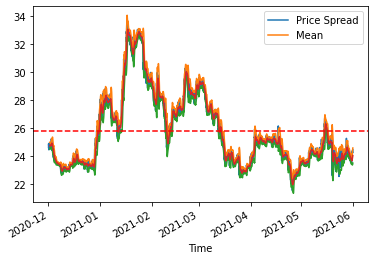

In [435]:
eval_spread.plot() # Plot the spread
bb_h.plot()
bb_l.plot()
bb_m.plot()
plt.axhline(eval_spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

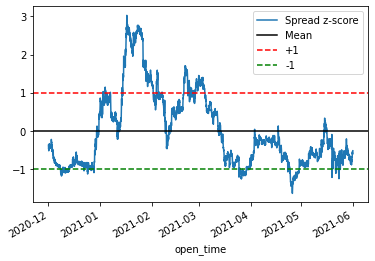

In [436]:
zscore(eval_spread).plot()
plt.axhline(zscore(eval_spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])